In [1]:
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
from skimage import feature
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
    return features

In [5]:
def load_split(path):
    # grab the list of images in the input directory, then initialize
    # the list of data (i.e., images) and class labels
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]
        # load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        # threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image
        features = quantify_image(image)
        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))

In [40]:
!pip install imutils
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,PrecisionRecallDisplay,RocCurveDisplay,auc,roc_curve

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
def train_models(dataset):
    # initialize the models
    models = {
        "Rf": {
            "classifier": RandomForestClassifier(random_state=1),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        },
        "Xgb": {
            "classifier": XGBClassifier(),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        }
    }
    # define the path to the testing and training directories
    path = "/content/drive/MyDrive/dataset/" + dataset
    trainingPath = os.path.sep.join([path, "training"])
    testingPath = os.path.sep.join([path, "testing"])
    # load the data
    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)
    # encode the labels
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)

    # train each model and calculate its metrics
    for model in models:
        if(model=="Rf"):
            print("Random Forest Classifier: ")
        else:
            print("\nXGBoost Classifier")
        models[model]["classifier"].fit(trainX, trainY)
        predictions = models[model]["classifier"].predict(testX)
        cm = confusion_matrix(testY, predictions,labels=models[model]["classifier"].classes_)
        temp=cm.ravel()
        tn, fp, fn, tp = temp
        print("Confusion matrix: ")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=models[model]["classifier"].classes_)
        disp.plot()
        plt.show()
        print("Accuracy: ")
        print((tp + tn) / float(cm.sum()))
        print("Precision: ")
        p=tp/float(tp+fp)
        print(p)
        print("Recall: ")
        r=tp / float(tp + fn)
        print(r)
        print("Specificity")
        print(tn / float(tn + fp))
        print("F1 score: ")
        print((2*p*r)/(p+r))
        print("\nPecision-Recall Curve:\n")
        display = PrecisionRecallDisplay.from_estimator(models[model]["classifier"],testX,testY, name=model)
        plt.show()
        print("\nROC curve: \n")
        fpr, tpr, thresholds = roc_curve(testY, predictions)
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=model)
        display.plot()
        plt.show()
    return models

Random Forest Classifier: 
Confusion matrix: 


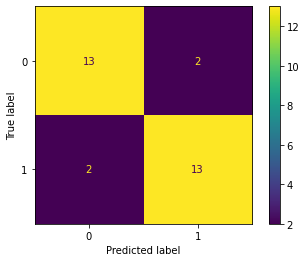

Accuracy: 
0.8666666666666667
Precision: 
0.8666666666666667
Recall: 
0.8666666666666667
Specificity
0.8666666666666667
F1 score: 
0.8666666666666667

Pecision-Recall Curve:



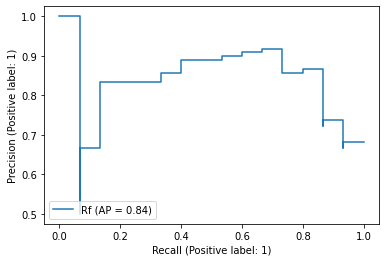


ROC curve: 



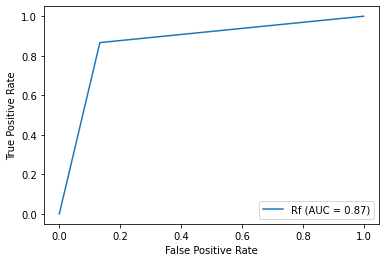


XGBoost Classifier
Confusion matrix: 


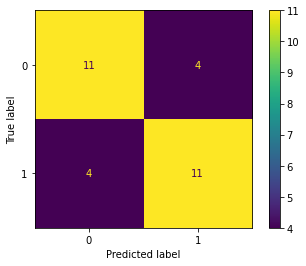

Accuracy: 
0.7333333333333333
Precision: 
0.7333333333333333
Recall: 
0.7333333333333333
Specificity
0.7333333333333333
F1 score: 
0.7333333333333333

Pecision-Recall Curve:



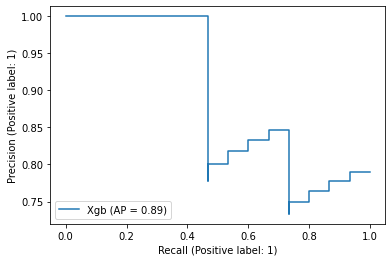


ROC curve: 



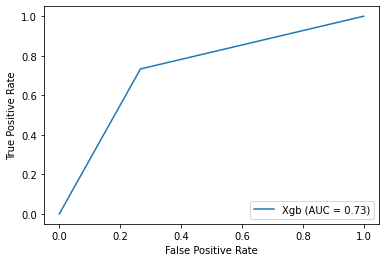

In [44]:
# Train the models on the spiral drawings
spiralModels = train_models('spiral')

Random Forest Classifier: 
Confusion matrix: 


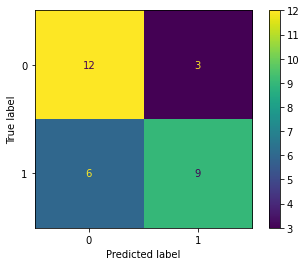

Accuracy: 
0.7
Precision: 
0.75
Recall: 
0.6
Specificity
0.8
F1 score: 
0.6666666666666665

Pecision-Recall Curve:



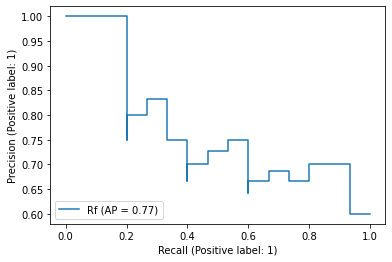


ROC curve: 



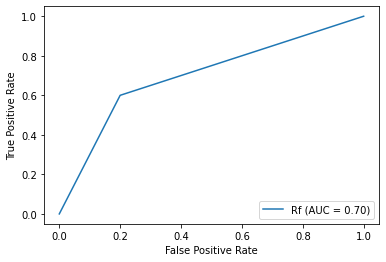


XGBoost Classifier
Confusion matrix: 


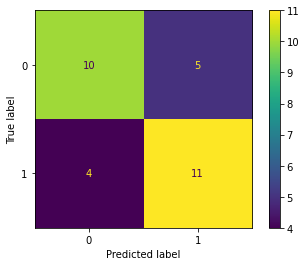

Accuracy: 
0.7
Precision: 
0.6875
Recall: 
0.7333333333333333
Specificity
0.6666666666666666
F1 score: 
0.7096774193548386

Pecision-Recall Curve:



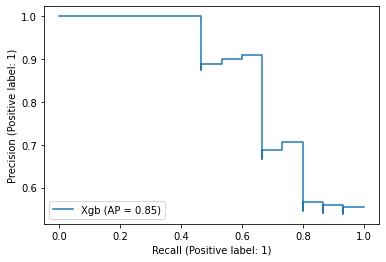


ROC curve: 



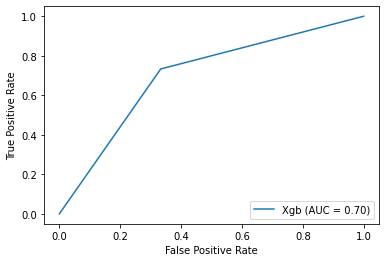

In [45]:
waveModels = train_models('wave')

In [46]:
import joblib

In [47]:
joblib.dump(spiralModels['Rf']['classifier'],"./spi.pkl")

['./spi.pkl']

In [48]:
joblib.dump(waveModels['Rf']['classifier'],"./wave.pkl")

['./wave.pkl']